In [7]:
#This script is to calculate point-dipole interaction between texas-red and other molecules.
#Tex-Lut
#Tex-CLA 612 613 614
#Tex-xxx

#22/May/2021 TJ:
#To show the data on the lumen side(the other side), we flip all Texas Red Dipole moments over the plane: z = 44. 
#Also fix the Qx/Qy ratio from 0.67 to 0.45

import numpy as np
from scipy import constants
import matplotlib.pyplot as plt
import os


orientation_factor = []    #List used to track changes on orientations. 

#load vector here
def norm_vector(vector_list):
    vector_normed = []
    for vector in vector_list:
        #print(vector)
        vector_normed.append(vector/np.linalg.norm(vector))
        #print(vector_normed)
    return np.asarray(vector_normed)

def vector_length(vector):
    x,y,z = vector
    return ((x**2+y**2+z**2)**0.5)


def calc_H(dipole1, dipole2, center_vector, dipole_str1, dipole_str2):
    """
    dipole1 and dipole2 are the unit vector in line with its transition dipole moments of Texas-Red and Chlorophyll a.
    center_vector is the vector from one of their center to the other
    r is the distance, which can be caluclated from center_vector
    
    
    ***UNIT***
    dipoles are coming in C*m.
    distance is measured in angstroem
    output H is in meV
    
    """  
    center_vector_normed = center_vector/np.linalg.norm(center_vector)
    
    r = np.linalg.norm(center_vector)   #here r is in angstrom
    r = r*1.0e-10                       #here r is in meter.
    #print("The center vector length is %s" % str(r))
    
    H = -((dipole_str1*dipole_str2)/(4 * constants.pi * 2*permeability_factor * r**3))*\
    (3*np.dot(dipole1,center_vector_normed)*np.dot(dipole2, center_vector_normed) - np.dot(dipole1, dipole2))
    
    orientation_factor.append(3*np.dot(dipole1,center_vector_normed)*np.dot(dipole2, center_vector_normed))
    
    #print("the distance is here: %s" %r)
    return (H*6.242e+21)    #convert H from joules to meV


def load_raw_vector(filename):
    """
    Given file name under the current directory, load the raw data x, y, z, starting x, starting y, starting z.
    file is loaded as array[framenumber, 7], like this
    array([ 1.    , -2.3211,  3.6332, -2.0481, 82.9937, 14.6032, 56.2966])
        
    
    And return as a dictionary as requested to vector and vector_start:
    [
    [x,y,z]
    [x,y,z]
    ...
    ]
    """
    filedata = np.loadtxt(filename)
    vector = filedata[:,1:4]
    #print(vector.shape)
    vector_start = filedata[:,4:]
    return ({"vector": vector, "vector_start": vector_start})


def Average(lst): 
    lst = lst[-3000:]
    sumup = 0
    for elements in lst:
        sumup += abs(elements)
    return ( sumup / len(lst) )

In [8]:
def flip_the_vector(vector):
    """
    input is in shape [?,3]: (x,y,z)
    
    output is (x,)
    
    we have set the plane to z = 44.
    """
    plane_height = 44
    
    vector['vector'][:,-1] = vector['vector'][:,-1] * -1 # flip the vector
    
    vector['vector_start'][:,-1] = plane_height - (vector['vector_start'][:,-1] - plane_height) # flip the vector_start
    
    return vector



In [9]:
CLA_Dipole = 4.5  ###5.524   #in Debye
CHL_Dipole = 3.8  ###4.595  #In Debye
Tex_Dipole = 10   ###20   #In Debye


CLA_Dipole *= 3.3356e-30    #in C*m
CHL_Dipole *= 3.3356e-30    #in C*m
Tex_Dipole *= 3.3356e-30    #in C*m

permeability_factor = 8.8541878e-12  




#CLA610_Dipole = norm_vector(load_raw_vector("cla610_dipole.dat")["vector"])
#Tex1_Dipole = norm_vector(load_raw_vector("tex1_dipole.dat")["vector"])

#center_vectors = load_raw_vector("tex1_dipole.dat")["vector_start"] - load_raw_vector("cla610_dipole.dat")["vector_start"]

#print(Tex1_Dipole.shape)
#CLA610_start = load_vector_start("cla610_dipole.dat")
#Tex1_start = load_vector_start("tex1_dipole.dat")


In [147]:
Coupling_avg_list = []
Coupling_avg_name_list = []
def plot_dipole(mol1, mol2):
    """
    define a function plot the result providing two keywords.
    mol1, mol2 is a string.
    
    y-axis unit in meV.
    x-axis: every 1000 frames represents 20ns trajectory.
    """
    flip_status = False #change to True when calculate the flipped texas red dipole.
    copy_number = 1
    
    #loading the data
    print("loading data for %s and %s"  %(mol1,mol2))
    mol1_vector = load_raw_vector(mol1)
    mol2_vector = load_raw_vector(mol2)
    
    if flip_status == True:
        mol1_vector = flip_the_vector(mol1_vector)
    
    
    #print(mol1_vector.shape, mol2_vector.shape)
    print("data loading complete")
    
    mol1_dipole = norm_vector(mol1_vector['vector'])
    mol2_dipole = norm_vector(mol2_vector['vector'])
    center_vectors = mol1_vector["vector_start"] - mol2_vector["vector_start"]
    

    dipole_str2 = Tex_Dipole
    
    if "cla" in mol2:
        dipole_str1 = CLA_Dipole
    elif "chl" in mol2:
        dipole_str1 = CHL_Dipole
    
    if "Qx" in mol2:
        dipole_str1 *= 0.45   #changed from 0.67 to 0.45
    
    #here starts the dipole interaction calculation#
    H_list = []    #The couplings are stored in H_list
    orientation_factor = []    #List used to track changes on orientations. 
    for i, dipole1 in enumerate(mol1_dipole):
        #print(dipole1,i)
        dipole2 = mol2_dipole[i]
        center_vector = center_vectors[i]
    
        #print("Calculating the %s frame." % i)
        H_list.append(calc_H(dipole1, dipole2, center_vector, dipole_str1, dipole_str2)) 

    print(mol1, mol2, dipole_str1/3.3356e-30, dipole_str2/3.3356e-30)
    
    #np.savetxt("./J_DATA/"+ (mol1[:4],mol2[:6]) + "_cp_" + str(np) +"_dipole.dat", np.array(H_list))
    np.savetxt("./J_DATA_FLIPPED/%s_%s_cp%d_dipole.dat" %(mol1[:4]+'flipped',mol2[:6],copy_number), np.array(H_list))
    
    
    #here we plot the data
    
    xaxis = np.arange(0.0, 3000, 1)
    plt.plot(xaxis,H_list)
    plt.title('%s and %s' %(mol1[:4],mol2[:6]), fontsize=10)
    #plt.title('%s and %s' %(mol1[:4]+'flipped',mol2[:6]), fontsize=10)#for flipping.
    plt.ylim(-1, 1)
    plt.ylabel("Coupling (meV)")
    plt.xlabel("Frame No.")
    #plt.savefig("./Fig/%s_%s.png" %(mol1[:-11], mol2[:-11]))

    Coupling_avg_list.append(Average(H_list))
    Coupling_avg_name_list.append(str("%s_%s" %(mol1, mol2)))
    
    
    #plt.set_ylabel('Couplings in Joules (J)')
    #plt.set_title('Couplings between the 4-cluster')



In [148]:
print(Coupling_avg_list, Coupling_avg_name_list)

[] []


loading data for tex1_dipole.dat and cla612_dipole.dat
data loading complete
tex1_dipole.dat cla612_dipole.dat 4.5 10.0


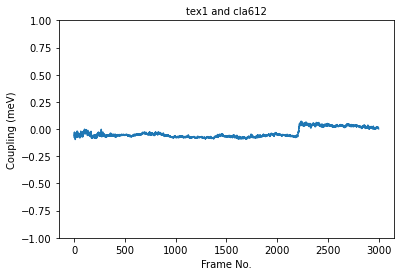

In [149]:
plot_dipole("tex1_dipole.dat","cla612_dipole.dat")

loading data for tex1_dipole.dat and cla611_dipole.dat
data loading complete
tex1_dipole.dat cla611_dipole.dat 4.5 10.0


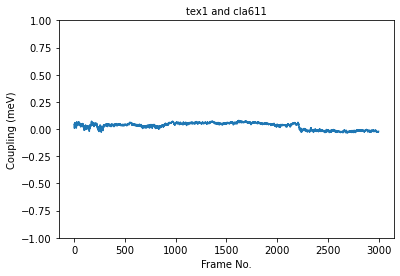

In [150]:
plot_dipole("tex1_dipole.dat","cla611_dipole.dat")

loading data for tex1_dipole.dat and cla612_dipole.dat
data loading complete
tex1_dipole.dat cla612_dipole.dat 4.5 10.0


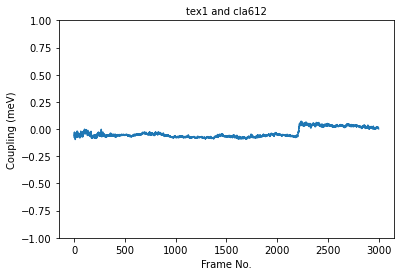

In [151]:
plot_dipole("tex1_dipole.dat","cla612_dipole.dat")

loading data for tex4_dipole.dat and cla610_dipole.dat
data loading complete
tex4_dipole.dat cla610_dipole.dat 4.5 10.0


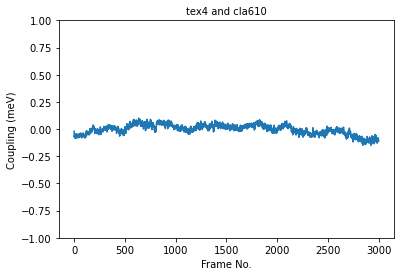

In [152]:
#########################
#TEX4 ANALYSIS START FROM HERE
#########################

plot_dipole("tex4_dipole.dat","cla610_dipole.dat")

loading data for tex4_dipole.dat and cla611_dipole.dat
data loading complete
tex4_dipole.dat cla611_dipole.dat 4.5 10.0


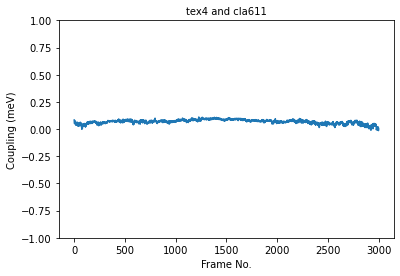

In [153]:
plot_dipole("tex4_dipole.dat","cla611_dipole.dat")

loading data for tex4_dipole.dat and cla612_dipole.dat
data loading complete
tex4_dipole.dat cla612_dipole.dat 4.5 10.0


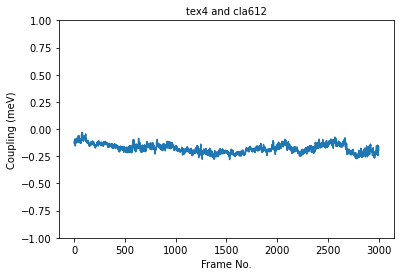

In [154]:
plot_dipole("tex4_dipole.dat","cla612_dipole.dat")

loading data for tex1_dipole.dat and chl601_dipole.dat
data loading complete
tex1_dipole.dat chl601_dipole.dat 3.8 10.0


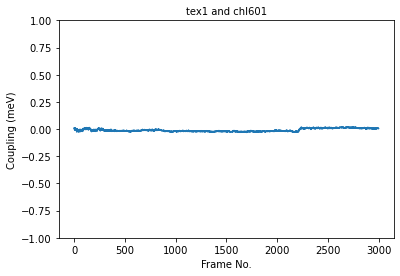

In [155]:
plot_dipole("tex1_dipole.dat","chl601_dipole.dat")

loading data for tex1_dipole.dat and chl608_dipole.dat
data loading complete
tex1_dipole.dat chl608_dipole.dat 3.8 10.0


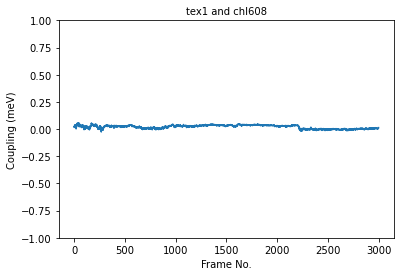

In [156]:
plot_dipole("tex1_dipole.dat","chl608_dipole.dat")

loading data for tex4_dipole.dat and chl601_dipole.dat
data loading complete
tex4_dipole.dat chl601_dipole.dat 3.8 10.0


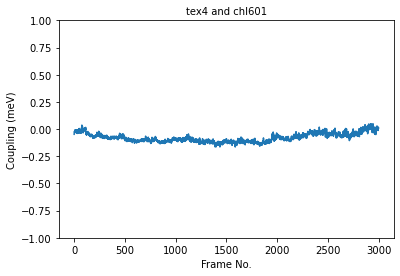

In [157]:
plot_dipole("tex4_dipole.dat","chl601_dipole.dat")

loading data for tex4_dipole.dat and chl608_dipole.dat
data loading complete
tex4_dipole.dat chl608_dipole.dat 3.8 10.0


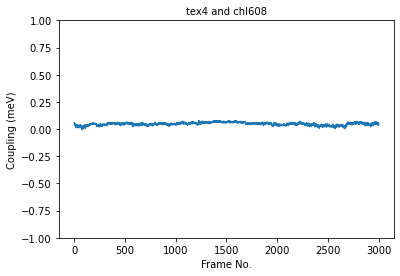

In [158]:
plot_dipole("tex4_dipole.dat","chl608_dipole.dat")

loading data for tex1_dipole.dat and cla610_Qx_dipole.dat
data loading complete
tex1_dipole.dat cla610_Qx_dipole.dat 2.025 10.0


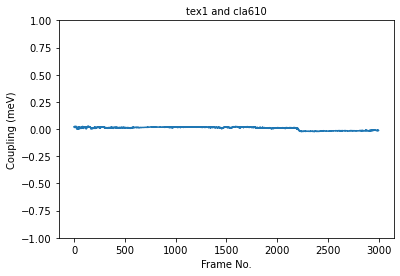

In [159]:
####Qx coupling Calculations starts here
plot_dipole("tex1_dipole.dat","cla610_Qx_dipole.dat")


loading data for tex1_dipole.dat and cla611_Qx_dipole.dat
data loading complete
tex1_dipole.dat cla611_Qx_dipole.dat 2.025 10.0


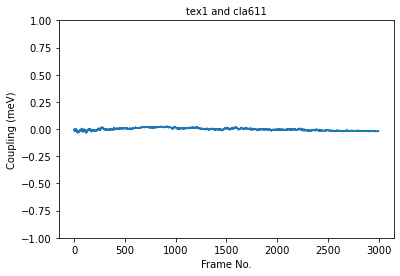

In [160]:
plot_dipole("tex1_dipole.dat","cla611_Qx_dipole.dat")


loading data for tex1_dipole.dat and cla612_Qx_dipole.dat
data loading complete
tex1_dipole.dat cla612_Qx_dipole.dat 2.025 10.0


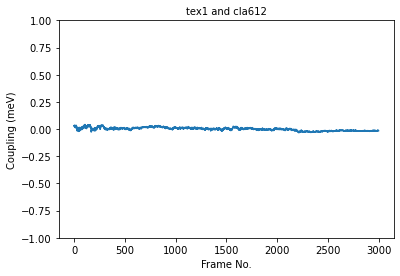

In [161]:
plot_dipole("tex1_dipole.dat","cla612_Qx_dipole.dat")


loading data for tex4_dipole.dat and cla610_Qx_dipole.dat
data loading complete
tex4_dipole.dat cla610_Qx_dipole.dat 2.025 10.0


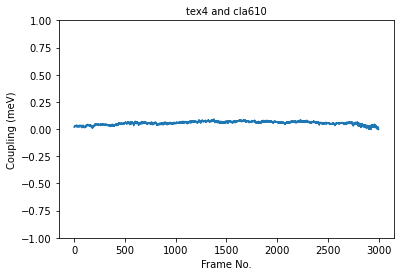

In [162]:
plot_dipole("tex4_dipole.dat","cla610_Qx_dipole.dat")


loading data for tex4_dipole.dat and cla611_Qx_dipole.dat
data loading complete
tex4_dipole.dat cla611_Qx_dipole.dat 2.025 10.0


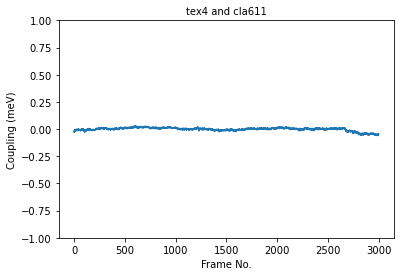

In [163]:
plot_dipole("tex4_dipole.dat","cla611_Qx_dipole.dat")


loading data for tex4_dipole.dat and cla612_Qx_dipole.dat
data loading complete
tex4_dipole.dat cla612_Qx_dipole.dat 2.025 10.0


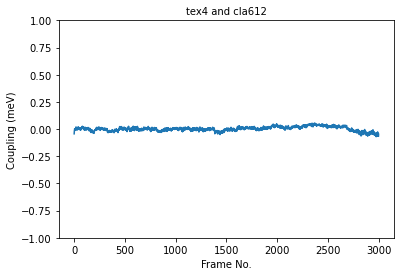

In [164]:
plot_dipole("tex4_dipole.dat","cla612_Qx_dipole.dat")


In [165]:
##Here starts Qx, Chl calculations


loading data for tex1_dipole.dat and chl601_Qx_dipole.dat
data loading complete
tex1_dipole.dat chl601_Qx_dipole.dat 1.71 10.0


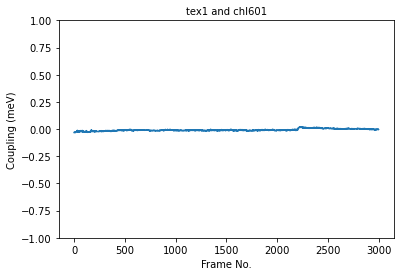

In [166]:
plot_dipole("tex1_dipole.dat","chl601_Qx_dipole.dat")


loading data for tex1_dipole.dat and chl608_Qx_dipole.dat
data loading complete
tex1_dipole.dat chl608_Qx_dipole.dat 1.71 10.0


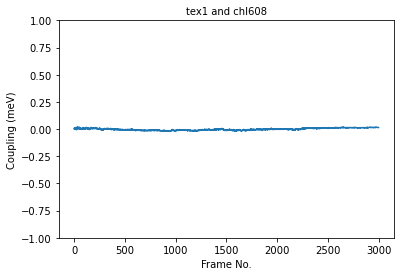

In [167]:
plot_dipole("tex1_dipole.dat","chl608_Qx_dipole.dat")

loading data for tex4_dipole.dat and chl601_Qx_dipole.dat
data loading complete
tex4_dipole.dat chl601_Qx_dipole.dat 1.71 10.0


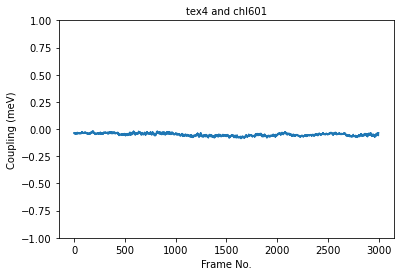

In [168]:
plot_dipole("tex4_dipole.dat","chl601_Qx_dipole.dat")


loading data for tex4_dipole.dat and chl608_Qx_dipole.dat
data loading complete
tex4_dipole.dat chl608_Qx_dipole.dat 1.71 10.0


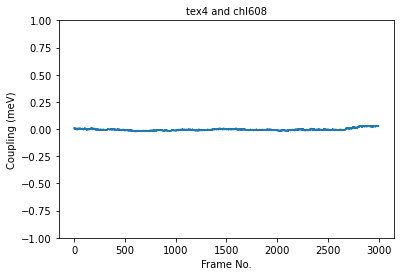

In [169]:
plot_dipole("tex4_dipole.dat","chl608_Qx_dipole.dat")

In [170]:
print(Coupling_avg_list)

[0.05314839092936935, 0.037220029858583956, 0.05314839092936935, 0.03656398894916312, 0.06805254985942995, 0.17760313418600931, 0.01517303101207327, 0.021584356812064193, 0.07959962309314636, 0.04759649685505635, 0.015309112602454567, 0.010010099586210519, 0.011886763776807825, 0.05493750439169943, 0.010675986506525901, 0.015908474699872846, 0.010924035832064746, 0.008410680607873994, 0.05078958332065898, 0.009059715411584743]


In [171]:
print(Coupling_avg_name_list)

['tex1_dipole.dat_cla612_dipole.dat', 'tex1_dipole.dat_cla611_dipole.dat', 'tex1_dipole.dat_cla612_dipole.dat', 'tex4_dipole.dat_cla610_dipole.dat', 'tex4_dipole.dat_cla611_dipole.dat', 'tex4_dipole.dat_cla612_dipole.dat', 'tex1_dipole.dat_chl601_dipole.dat', 'tex1_dipole.dat_chl608_dipole.dat', 'tex4_dipole.dat_chl601_dipole.dat', 'tex4_dipole.dat_chl608_dipole.dat', 'tex1_dipole.dat_cla610_Qx_dipole.dat', 'tex1_dipole.dat_cla611_Qx_dipole.dat', 'tex1_dipole.dat_cla612_Qx_dipole.dat', 'tex4_dipole.dat_cla610_Qx_dipole.dat', 'tex4_dipole.dat_cla611_Qx_dipole.dat', 'tex4_dipole.dat_cla612_Qx_dipole.dat', 'tex1_dipole.dat_chl601_Qx_dipole.dat', 'tex1_dipole.dat_chl608_Qx_dipole.dat', 'tex4_dipole.dat_chl601_Qx_dipole.dat', 'tex4_dipole.dat_chl608_Qx_dipole.dat']


In [146]:
np.savetxt("coupling_avg.txt", Coupling_avg_name_list)

TypeError: Mismatch between array dtype ('<U36') and format specifier ('%.18e')